# The German Traffic Sign Benchmark


Student Name 1: Daniel Minguez Camacho

Student Name 2: Javier de la Rúa Martínez

## Data preparation

Download full data set from http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset

In [1]:
# Get data
!if [ ! -f FullIJCNN2013.zip ]; then wget -c http://benchmark.ini.rub.de/Dataset_GTSDB/FullIJCNN2013.zip; else echo "Already downloaded"; fi
    
# Unzip file
!if [ ! -d FullIJCNN2013 ]; then unzip FullIJCNN2013.zip; else echo "Already unzipped"; fi

--2019-04-08 16:15:20--  http://benchmark.ini.rub.de/Dataset_GTSDB/FullIJCNN2013.zip
Resolving benchmark.ini.rub.de (benchmark.ini.rub.de)... 134.147.122.15
Connecting to benchmark.ini.rub.de (benchmark.ini.rub.de)|134.147.122.15|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1661866983 (1.5G) [application/zip]
Saving to: ‘FullIJCNN2013.zip’

FullIJCNN2013.zip   100%[===================>]   1.55G  9.22MB/s    in 5m 6s   

2019-04-08 16:20:27 (5.18 MB/s) - ‘FullIJCNN2013.zip’ saved [1661866983/1661866983]

Archive:  FullIJCNN2013.zip
   creating: FullIJCNN2013/
   creating: FullIJCNN2013/00/
  inflating: FullIJCNN2013/00000.ppm  
  inflating: FullIJCNN2013/00001.ppm  
  inflating: FullIJCNN2013/00002.ppm  
  inflating: FullIJCNN2013/00003.ppm  
  inflating: FullIJCNN2013/00004.ppm  
  inflating: FullIJCNN2013/00005.ppm  
  inflating: FullIJCNN2013/00006.ppm  
  inflating: FullIJCNN2013/00007.ppm  
  inflating: FullIJCNN2013/00008.ppm  
  inflating: FullIJCNN201

In [0]:
import numpy as np
import cv2

IMG_HEIGHT = 600
SIGN_SIZE = (224, 224)

# Function for reading the images
def readImages(rootpath, images_range, signs_range):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example 'FullIJCNN2013'
    Returns:   list of images, list of corresponding labels'''
    images = {} # original image
    scales = {} # original scale
    for num in images_range:
        filename = rootpath + '/' + "{:05d}".format(num) + '.ppm'
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        scale = IMG_HEIGHT / float(img.shape[0])
        img_resized = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
        images.setdefault(filename,[]).append(img_resized)
        scales.setdefault(filename,[]).append(scale)

    files = [] # filenames
    signs = [] # traffic sign image
    bboxes = [] # corresponding box detection
    labels = [] # traffic sign type
    data = np.genfromtxt(rootpath + '/' + 'gt.txt', delimiter=';', dtype=str, usecols=range(0, 6))
    for elem in signs_range:
        filename = rootpath + '/' + data[elem][0]
        img = images.get(filename)[0]
        scale = scales.get(filename)[0]
        bbox = np.array([int(data[elem][1]), int(data[elem][2]), int(data[elem][3]), int(data[elem][4])]) * scale
        sign = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        sign_resized = cv2.resize(sign, SIGN_SIZE)
        files.append(filename)
        signs.append(sign_resized)
        bboxes.append(bbox)
        labels.append(data[elem][5])
    return images, files, signs, bboxes, labels

In [0]:
# The German Traffic Sign Recognition Benchmark
train_images, train_files, train_signs, train_bboxes, train_labels = readImages('FullIJCNN2013', range(0,600), range(0,852))
test_images, test_files, test_signs, test_bboxes, test_labels = readImages('FullIJCNN2013', range(600,900), range(852,1213))

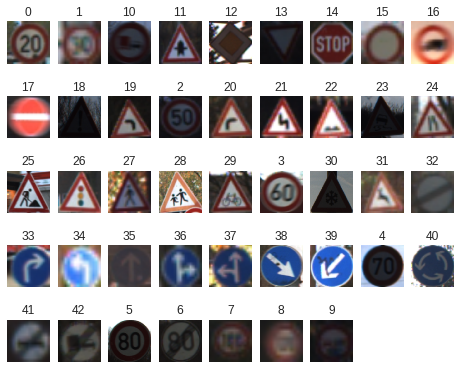

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Show examples from each class
class_names = np.unique(train_labels)
num_classes = len(class_names)
fig = plt.figure(figsize=(8,8))
for i in range(num_classes):
    ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    indices = np.where(np.isin(train_labels, class_names[i]))[0]
    plt.imshow(cv2.cvtColor(train_signs[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
plt.show()

In [5]:
from sklearn.utils import shuffle
train_files, train_signs, train_bboxes, train_labels = shuffle(train_files, train_signs, train_bboxes, train_labels)
# plt.imshow(cv2.cvtColor(train_images.get(train_files[0])[0], cv2.COLOR_BGR2RGB))
# plt.show()
# plt.imshow(cv2.cvtColor(train_signs[0], cv2.COLOR_BGR2RGB))
# plt.show()
# print(train_bboxes[0])
# print(train_labels[0])

# Data pre-processing
tr_signs = np.array(train_signs)[0:600]
tr_labels = np.array(train_labels)[0:600]
va_signs = np.array(train_signs)[600:852]
va_labels = np.array(train_labels)[600:852]
te_signs = np.array(test_signs)
te_labels = np.array(test_labels)

tr_signs = tr_signs.astype('float32')
va_signs = va_signs.astype('float32')
te_signs = te_signs.astype('float32')
tr_signs /= 255.0
va_signs /= 255.0
te_signs /= 255.0

from keras.utils import np_utils
tr_labels = np_utils.to_categorical(tr_labels, num_classes)
va_labels = np_utils.to_categorical(va_labels, num_classes)
te_labels = np_utils.to_categorical(te_labels, num_classes)

Using TensorFlow backend.


## Assignment 3.3: Transfer learning

### Modelling

In [6]:
from keras.applications.xception import Xception
from keras.layers import Dense, GlobalMaxPooling2D
from keras.models import Model
from keras.optimizers import Adam

baseline = Xception(include_top=False, weights='imagenet', input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3))

x = GlobalMaxPooling2D()(baseline.layers[-2].output)
predictions = Dense(num_classes, activation='softmax')(x)

xception = Model(inputs=baseline.input, outputs=predictions)

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

xception.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
xception.summary()

Instructions for updating:
Colocations handled automatically by placer.
83689472/83683744 [==============================] - 8s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1

### Callbacks

In [0]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, Callback

class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        self.t_loss = []
        self.t_acc = []

    def on_epoch_end(self, epoch, logs):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        logs['test_loss'] = loss
        logs['test_acc'] = acc
        print('\nT_loss: {}, T_acc: {}\n'.format(loss, acc))

# tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

In [0]:
callbacks = [ModelCheckpoint(filepath='best_model_2.h5', monitor='val_loss', save_best_only=True),
             TensorBoard(log_dir='logs/{}'.format(time())),
             TestCallback((te_signs, te_labels))]

### Evaluation with Data Augmentation

#### Data Augmentation

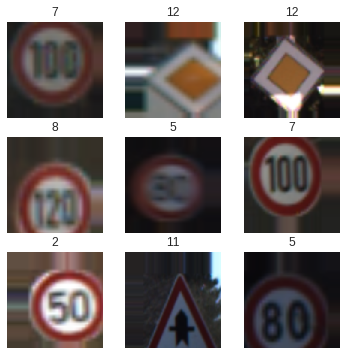

In [9]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=(0.9, 1.25), fill_mode='nearest')
datagen.fit(tr_signs, augment=True)

for x_batch, y_batch in datagen.flow(tr_signs, tr_labels, batch_size=9):
    # create a grid of 3x3 images
    fig = plt.figure(figsize=(6,6))
    for i in range(0, 9):
        ax = fig.add_subplot(3, 3, 1 + i, xticks=[], yticks=[])
        ax.set_title(np.argmax(y_batch[i]))
        plt.imshow(cv2.cvtColor(x_batch[i], cv2.COLOR_BGR2RGB))
    # show the plot
    plt.show()
    break

#### Evaluation

In [10]:
train_steps = int(len(tr_signs) / 16)
valid_steps = int(len(va_signs) / 16)

data = xception.fit_generator(datagen.flow(tr_signs, tr_labels, batch_size=16), epochs=100, steps_per_epoch=train_steps,
                              validation_data=(va_signs, va_labels), validation_steps=valid_steps, verbose=2,
                              callbacks=callbacks)
start = time()
loss, acc = xception.evaluate(te_signs, te_labels, verbose=0)
end = time()

print('Xception (with Data Augmentation) took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/100
 - 42s - loss: 2.3377 - acc: 0.4105 - val_loss: 1.4752 - val_acc: 0.6032

T_loss: 1.3712845733621444, T_acc: 0.6121883657335244

Epoch 2/100
 - 32s - loss: 1.2787 - acc: 0.6706 - val_loss: 2.0981 - val_acc: 0.5357

T_loss: 1.8662788257044107, T_acc: 0.5817174518537653

Epoch 3/100
 - 30s - loss: 0.8852 - acc: 0.7449 - val_loss: 1.1125 - val_acc: 0.7143

T_loss: 0.7308629001606864, T_acc: 0.8060941829905945

Epoch 4/100
 - 30s - loss: 0.6219 - acc: 0.8311 - val_loss: 1.5857 - val_acc: 0.6508

T_loss: 1.308152218769792, T_acc: 0.7008310252609675

Epoch 5/100
 - 30s - loss: 0.4391 - acc: 0.8784 - val_loss: 0.8581 - val_acc: 0.8135

T_loss: 0.8882534077953433, T_acc: 0.8171745154005668

Epoch 6/100
 - 30s - loss: 0.4368 - acc: 0.9038 - val_loss: 1.3091 - val_acc: 0.7103

T_loss: 1.0032004898109594, T_acc: 0.7534626040432262

Epoch 7/100
 - 30s - loss: 0.

#### History

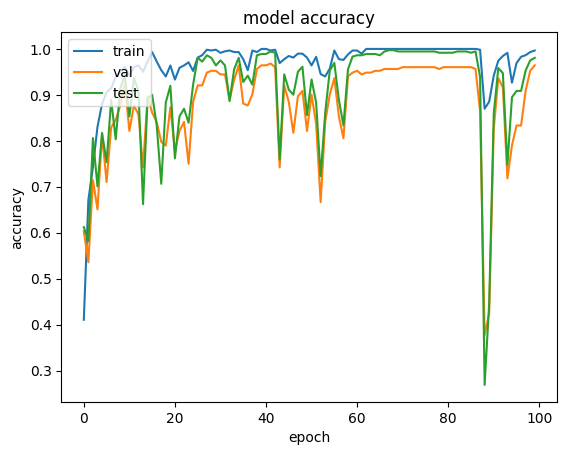

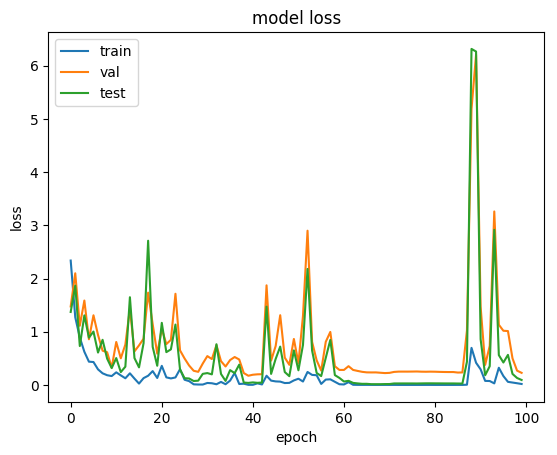

In [17]:
import matplotlib.pyplot as plt

plt.style.use('fast')

# summarize history for accuracy
plt.plot(data.history['acc'])
plt.plot(data.history['val_acc'])
plt.plot(data.history['test_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val', 'test'], loc='upper left')
plt.grid(False)
plt.show()

# summarize history for loss
plt.plot(data.history['loss'])
plt.plot(data.history['val_loss'])
plt.plot(data.history['test_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val', 'test'], loc='upper left')
plt.grid(False)
plt.show()

### Evaluation without Data Augmentation

#### Evaluation

In [20]:
train_steps = int(len(tr_signs) / 16)
valid_steps = int(len(va_signs) / 16)

data = xception.fit(tr_signs, tr_labels, batch_size=16, epochs=100, validation_data=(va_signs, va_labels), verbose=2, callbacks=callbacks)
start = time()
loss, acc = xception.evaluate(te_signs, te_labels, verbose=0)
end = time()

print('Xception (without Data Augmentation) took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

Train on 600 samples, validate on 252 samples
Epoch 1/100
 - 31s - loss: 0.0110 - acc: 0.9950 - val_loss: 0.2638 - val_acc: 0.9524

T_loss: 0.11877312518417135, T_acc: 0.9833795013850416

Epoch 2/100
 - 31s - loss: 0.0083 - acc: 0.9983 - val_loss: 0.3082 - val_acc: 0.9484

T_loss: 0.13519259939091985, T_acc: 0.9806094182825484

Epoch 3/100
 - 31s - loss: 0.0021 - acc: 1.0000 - val_loss: 0.2305 - val_acc: 0.9484

T_loss: 0.07957916338429409, T_acc: 0.9833795013850416

Epoch 4/100
 - 31s - loss: 0.0063 - acc: 0.9967 - val_loss: 0.2933 - val_acc: 0.9524

T_loss: 0.0982671631122924, T_acc: 0.9833795013850416

Epoch 5/100
 - 31s - loss: 0.0190 - acc: 0.9967 - val_loss: 0.6687 - val_acc: 0.9048

T_loss: 0.2505399388392711, T_acc: 0.9612188368953166

Epoch 6/100
 - 31s - loss: 0.0210 - acc: 0.9917 - val_loss: 1.9804 - val_acc: 0.7976

T_loss: 2.4752821869467105, T_acc: 0.753462604125781

Epoch 7/100
 - 31s - loss: 0.0398 - acc: 0.9900 - val_loss: 0.8122 - val_acc: 0.8849

T_loss: 0.4415713841

#### History

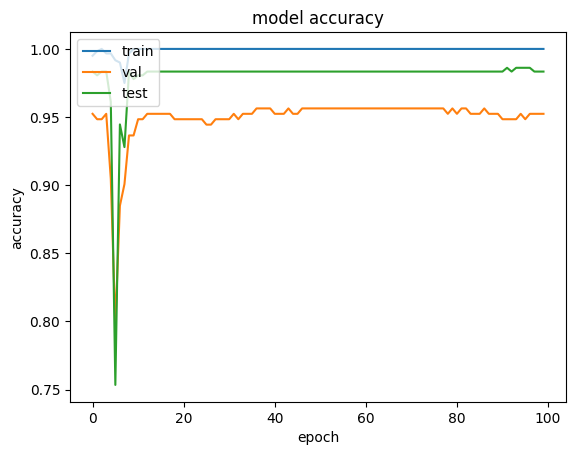

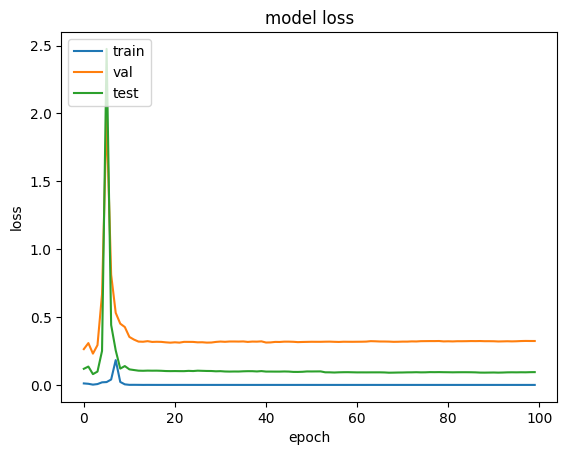

In [21]:
import matplotlib.pyplot as plt

plt.style.use('fast')

# summarize history for accuracy
plt.plot(data.history['acc'])
plt.plot(data.history['val_acc'])
plt.plot(data.history['test_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val', 'test'], loc='upper left')
plt.grid(False)
plt.show()

# summarize history for loss
plt.plot(data.history['loss'])
plt.plot(data.history['val_loss'])
plt.plot(data.history['test_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val', 'test'], loc='upper left')
plt.grid(False)
plt.show()

### Evaluation with EarlyStopping

In [0]:
from keras.callbacks import EarlyStopping

callbacks.append(EarlyStopping(monitor='val_acc', patience=4))

In [24]:
train_steps = int(len(tr_signs) / 16)
valid_steps = int(len(va_signs) / 16)

data = xception.fit(tr_signs, tr_labels, batch_size=16, epochs=100, validation_data=(va_signs, va_labels), verbose=2, callbacks=callbacks)
start = time()
loss, acc = xception.evaluate(te_signs, te_labels, verbose=0)
end = time()

print('Xception (without Data Augmentation) and EarlyStopping took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

Train on 600 samples, validate on 252 samples
Epoch 1/100
 - 31s - loss: 3.4605e-06 - acc: 1.0000 - val_loss: 0.3238 - val_acc: 0.9524

T_loss: 0.09395291342049276, T_acc: 0.9833795013850416

Epoch 2/100
 - 31s - loss: 2.4791e-06 - acc: 1.0000 - val_loss: 0.3239 - val_acc: 0.9524

T_loss: 0.09437018469232276, T_acc: 0.9833795013850416

Epoch 3/100
 - 31s - loss: 1.6520e-06 - acc: 1.0000 - val_loss: 0.3235 - val_acc: 0.9524

T_loss: 0.09373791174157528, T_acc: 0.9833795013850416

Epoch 4/100
 - 31s - loss: 1.7723e-06 - acc: 1.0000 - val_loss: 0.3237 - val_acc: 0.9524

T_loss: 0.09319229971496497, T_acc: 0.9861495844875346

Epoch 5/100
 - 31s - loss: 5.7792e-06 - acc: 1.0000 - val_loss: 0.3235 - val_acc: 0.9524

T_loss: 0.09337504962899154, T_acc: 0.9833795013850416

Xception (without Data Augmentation) and EarlyStopping took 4.3570168018341064 seconds
Test loss: 0.09337504962899154 - Accuracy: 0.9833795013850416


### History

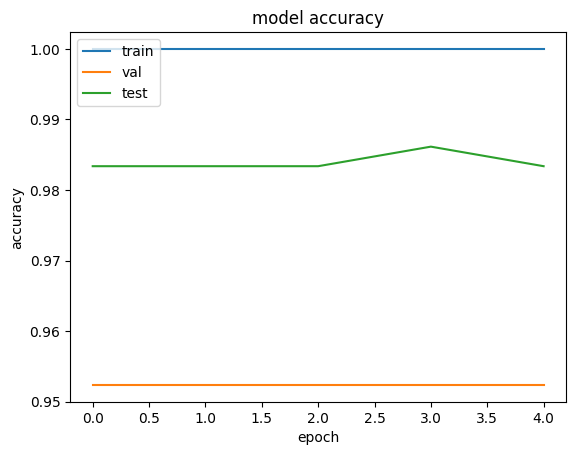

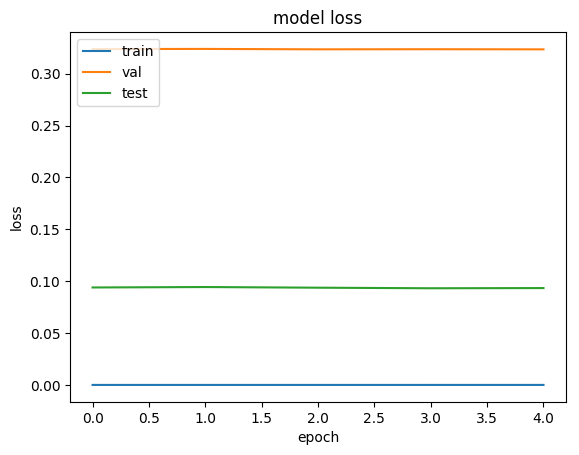

In [25]:
import matplotlib.pyplot as plt

plt.style.use('fast')

# summarize history for accuracy
plt.plot(data.history['acc'])
plt.plot(data.history['val_acc'])
plt.plot(data.history['test_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val', 'test'], loc='upper left')
plt.grid(False)
plt.show()

# summarize history for loss
plt.plot(data.history['loss'])
plt.plot(data.history['val_loss'])
plt.plot(data.history['test_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val', 'test'], loc='upper left')
plt.grid(False)
plt.show()